# SpotMAX as a Python package

Here we show a simple example where we detect and quantify spots in synthetic data. 

While default parameters work with this simple image, we **highly recommend** reading the documentation in order to learn how to change the parameters. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import spotmax as sm

## Generate synthetic data

In [2]:
spots_radii = np.array([4, 6, 6])

spots_img, spots_gt_mask, spots_coords = sm.data.synthetic_spots(
    num_spots=20,
    shape=(25, 256, 256), 
    spots_radii=spots_radii, 
    noise_scale=0.05,
    noise_shape=0.03, 
    rng_seed=11
)
spots_img.shape

(25, 256, 256)

## Visualize max z-projection

Text(0.5, 1.0, 'Spots mask MAX z-projection')

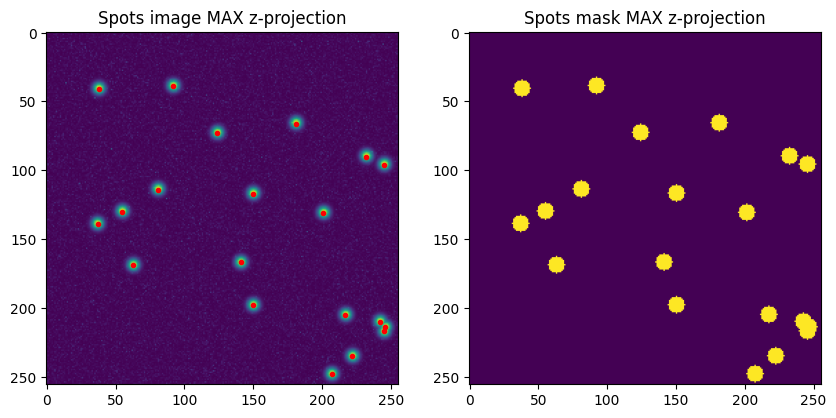

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(spots_img.max(axis=0))
ax[0].plot(spots_coords[:,2], spots_coords[:,1], 'r.')
ax[0].set_title('Spots image MAX z-projection')

ax[1].imshow(spots_gt_mask.max(axis=0))
# ax[1].plot(spots_coords[:,2], spots_coords[:,1], 'r.')
ax[1].set_title('Spots mask MAX z-projection')

## Segment spots
**Objective**: generate the same as ``spots_mask`` \
**Method**: try all thresholding methods and choose the best one (visually)

In [4]:
result = sm.pipe.spots_semantic_segmentation(
    spots_img, do_try_all_thresholds=True, do_sharpen=True
)

### Visualize max-projections of the result

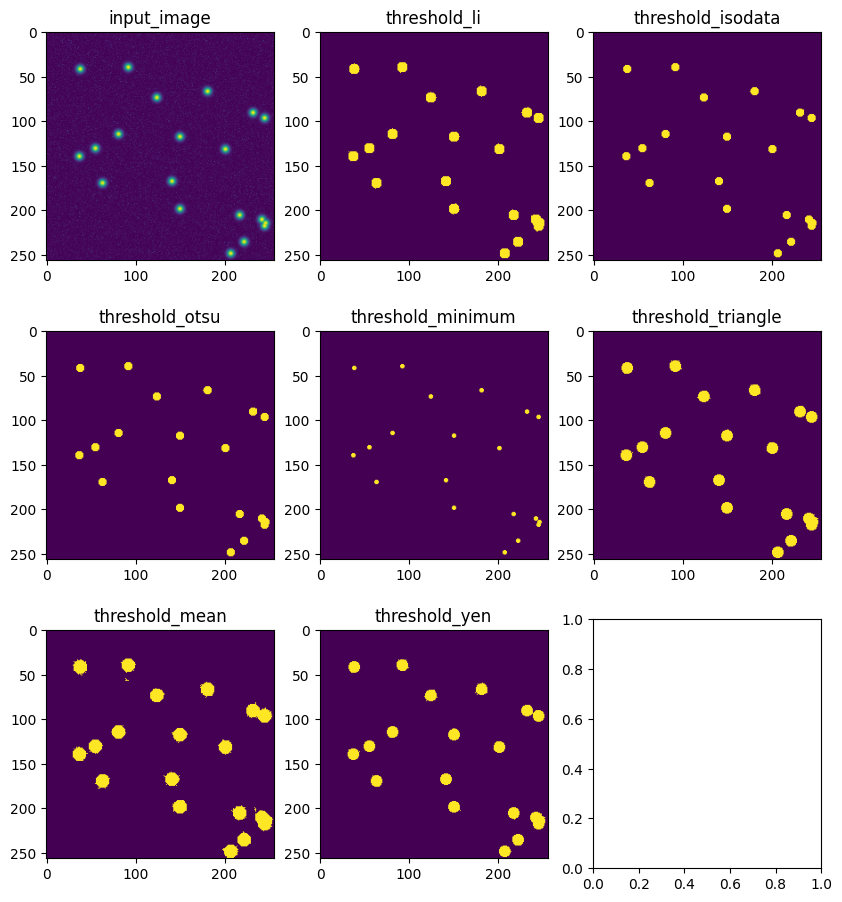

In [5]:
ncols = 3
nrows = len(result) // 3
nrows = nrows + 1 if len(result) % 3 else nrows
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 11))
ax = ax.flatten()
for a, (method, mask) in enumerate(result.items()):
    ax[a].imshow(mask.max(axis=0))
    ax[a].set_title(method)

## Detect the spots

**Objective**: detect center of the spots \
**Method**: Peak detection starting from ``threshold_otsu`` masks

By inspecting all the thresholding methods, we see that both ``threshold_otsu`` and ``threshold_isodata`` provide the best result, but to make SpotMAX life more complicated let's proceed with ``threshold_li``. 

In [6]:
spots_pred_mask = result['threshold_li'].astype(int)
spots_detect_img = result['input_image']
spots_zyx_radii_pxl = spots_radii

df_spots_coords, _ = sm.pipe.spot_detection(
    spots_detect_img, 
    spots_segmantic_segm=spots_pred_mask, 
    spots_zyx_radii_pxl=spots_zyx_radii_pxl, 
    return_df=True
)
print(f'Number of spots detected = {len(df_spots_coords)}')
df_spots_coords.head(10)

Number of spots detected = 20


z    y    x  z_local  y_local  x_local
Cell_ID spot_id                                         
1       1        20  205  217       20      205      217
        2        12  214  246       12      214      246
        3         6  217  245        6      217      245
        4         6   96  245        6       96      245
        5        13  117  150       13      117      150
        6        14  167  141       14      167      141
        7        16  248  207       16      248      207
        8        20  210  242       20      210      242
        9        17   41   38       17       41       38
        10        6   39   92        6       39       92

### Visualize spot detection

Text(0.5, 1.0, 'Spots mask MAX z-projection')

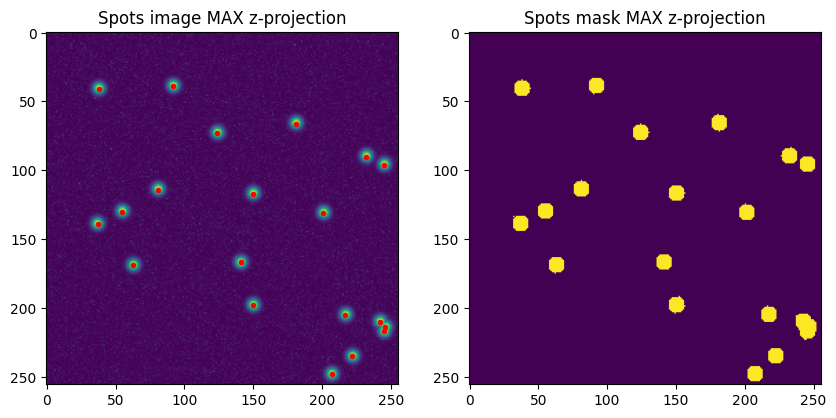

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(spots_detect_img.max(axis=0))
ax[0].plot(df_spots_coords['x'], df_spots_coords['y'], 'r.')
ax[0].set_title('Spots image MAX z-projection')

ax[1].imshow(spots_pred_mask.max(axis=0))
# ax[1].plot(spots_coords[:,2], spots_coords[:,1], 'r.')
ax[1].set_title('Spots mask MAX z-projection')

### Add false positives

Let's add 5 random false positives to see how we can filter them out

In [8]:
num_false_pos = 5
df_spots_coords = sm.data.add_random_coords_df(
    df_spots_coords, spots_img.shape, num_false_pos
)

df_spots_coords.tail(10)

z    y    x  z_local  y_local  x_local
Cell_ID spot_id                                         
1       16        5  169   63        5      169       63
        17       12  130   55       12      130       55
        18       14  139   37       14      139       37
        19        4   73  124        4       73      124
        20       14  114   81       14      114       81
        21        3  153  102        3      153      102
        22        3  182  237        3      182      237
        23       19    7  140       19        7      140
        24       12  124   18       12      124       18
        25       14   37  138       14       37      138

Let's also add **a more challenging false positive**, a spot whose distance from another spot is just one pixel more than the maximum distance allowed between spots. 

This can happen a lot with real-world data, but we can let SpotMAX find out that two spots in that are do not make sense. 

To do so, SpotMAX will fit one and two gaussian peaks to the two detections and the single peak will turn out to fit better. 

In [9]:
fp_zyx_coord = df_spots_coords.iloc[0][['z', 'y', 'x']].to_numpy()

# Add single pixel distance in the x direction to false positive
fp_zyx_coord[2] -= spots_radii[2]-1

new_spot_id = df_spots_coords.index.get_level_values(1).max() + 1

df_spots_coords = sm.data.add_point_df_spots(
    df_spots_coords, fp_zyx_coord, 1, new_spot_id
)
df_spots_coords.tail(5)

z    y    x  z_local  y_local  x_local
Cell_ID spot_id                                         
1       22        3  182  237        3      182      237
        23       19    7  140       19        7      140
        24       12  124   18       12      124       18
        25       14   37  138       14       37      138
        26       20  205  212       20      205      212

### Visualize spot detection with false positives

Text(0.5, 1.0, 'Spots mask MAX z-projection')

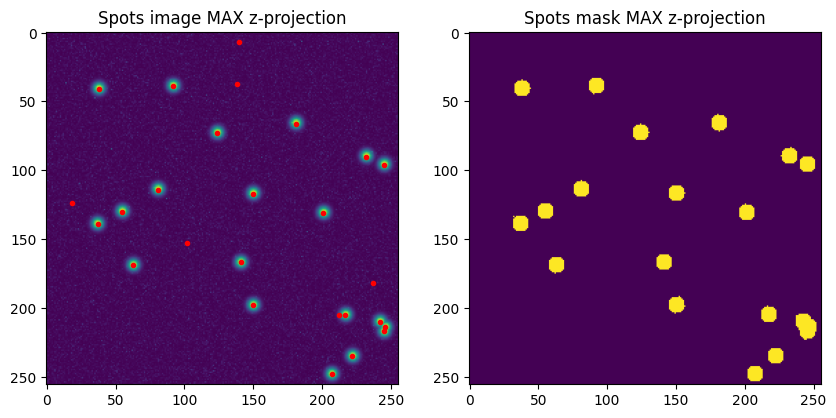

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(spots_detect_img.max(axis=0))
ax[0].plot(df_spots_coords['x'], df_spots_coords['y'], 'r.')
ax[0].set_title('Spots image MAX z-projection')

ax[1].imshow(spots_pred_mask.max(axis=0))
# ax[1].plot(spots_coords[:,2], spots_coords[:,1], 'r.')
ax[1].set_title('Spots mask MAX z-projection')

## Quantify and filter valid spots

For info about the calculated features see [here](https://spotmax.readthedocs.io//en/latest/features/single_spot_features_description.html)

In [11]:
keys, dfs_spots_det, dfs_spots_gop = sm.pipe.spots_calc_features_and_filter(
    spots_img, spots_zyx_radii_pxl, df_spots_coords, 
    sharp_spots_image=spots_detect_img, 
    optimise_for_high_spot_density=True, 
    show_progress=False, 
    verbose=False
)
columns = [
    'z', 'y', 'x', 'spot_center_raw_intensity', 
    'spot_vs_backgr_effect_size_glass'
]
df_spots = pd.concat(
    dfs_spots_gop, keys=keys, names=['frame_i', 'Cell_ID']).loc[0]
df_spots[columns].head(10)

z    y    x  spot_center_raw_intensity  spot_vs_backgr_effect_size_glass
Cell_ID spot_id                                                                           
1       1        20  205  217                   1.000000                         21.505761
        2        12  214  246                   0.998850                         18.338729
        3         6  217  245                   0.998800                         20.540047
        4         6   96  245                   0.995720                         20.346952
        5        13  117  150                   0.994681                         17.270537
        6        14  167  141                   0.993988                         17.765386
        7        16  248  207                   0.992724                         16.671747
        8        20  210  242                   0.992536                         21.511130
        9        17   41   38                   0.992487                         17.384104
        10        6   39   92                   0.992478                         20.401807

### Explore features to determine filtering thresholds

A useful feature to filter valid spots is the "Effect size" which is a measure 
of signal-to-noise ratio. 

SpotMAX calculates multiple types of effect sizes, here we will use the Glass' 
effect size. 

The simplest way to decide on the optimal threshold is to just sort by the effect size and see if we can spot a threshold value that would remove the false positives.

While here it is easy to spot a threshold value, real-world data is never this 
clear and we might have to use multiple features to filter. For example, 
we could use two features and to decide on a threshold value it might be helpful to plot these two features as a scatter plot and see if false positives 
cluster in some area of the plot. 

In spotMAX you can use as many features as you need and you can combine them with the logical operators AND, OR. 

For more info about the available effect sizes see [here](https://spotmax.readthedocs.io/en/latest/features/single_spot_features_description.html#effect-size-vs-backgr)

In [12]:
feature_name = 'spot_vs_backgr_effect_size_glass'
df_spots.sort_values(feature_name)[[feature_name]].head(10)

spot_vs_backgr_effect_size_glass
Cell_ID spot_id                                  
1       21                               0.009679
        22                               0.018655
        25                               0.021617
        24                               0.035966
        23                               0.069108
        26                               9.616688
        7                               16.671747
        13                              16.680629
        5                               17.270537
        11                              17.311541

Looking at the effect size it is clear that the 5 random false positives have a negative effect size, therefore we can filter with `spot_vs_backgr_effect_size_glass > 0`.

To do so, we repeat the `sm.pipe.spots_calc_features_and_filter` step where we provide the filtering features and thresholds. 

While we might have filtered the output table directly, it is recommended to let spotMAX do it when computing the features. This is because spotMAX runs multiple filtering iterations until the number of spots does not decrease anymore. 

Here we will need only one iteration, but with real-world data we might need 3 or 4 iterations. 

In [13]:
gop_filtering_thresholds = sm.config.get_features_thresholds_filter(
    'spot_vs_backgr_effect_size_glass, 0'
)

keys, dfs_spots_det, dfs_spots_gop = sm.pipe.spots_calc_features_and_filter(
    spots_img, spots_zyx_radii_pxl, df_spots_coords, 
    sharp_spots_image=spots_detect_img, 
    gop_filtering_thresholds=gop_filtering_thresholds,
    optimise_for_high_spot_density=True, 
    show_progress=False, 
    verbose=True
)
df_spots = pd.concat(
    dfs_spots_gop, keys=keys, names=['frame_i', 'Cell_ID']).loc[0]
df_spots[columns].tail(10)


Filtering valid spots...

**************************************************************************
Frame n. 1: number of spots after filtering valid spots based on features:

All spots are valid
--------------------------------------------------------------------------


z    y    x  spot_center_raw_intensity  spot_vs_backgr_effect_size_glass
Cell_ID spot_id                                                                           
1       17       12  130   55               9.924676e-01                         18.216182
        18       14  139   37               9.924676e-01                         17.728812
        19        4   73  124               9.924676e-01                         21.590240
        20       14  114   81               9.924676e-01                         17.776936
        21        3  153  102               7.041066e-03                          0.009679
        22        3  182  237               7.434406e-08                          0.018655
        23       19    7  140               2.583571e-18                          0.069108
        24       12  124   18               5.231453e-15                          0.035966
        25       14   37  138               1.658758e-05                          0.021617
        26       20  205  212               2.474744e-01                          9.616688

We can see that spotMAX removed the 5 random false positives, however, the stubborn spot_id 26 is still included. 

While we could have filtered with higher effect size threshold (e.g., 10) there are other ways to remove false positives, like fitting one and two gaussian peaks on each pair of spots and check if single peak fits better than one. 

To do so, we use the `spots_pred_mask` array generated during the `sm.pipe.spots_semantic_segmentation` step to determine the pairs of touching spots to check. 

### Quantify spots with spotFIT

**Objective**: fit 3D gaussian functions to spots

In [14]:
spotfit_kernel = sm.core.SpotFIT()
df_spotfit, _ = sm.pipe.spotfit(
    spotfit_kernel, spots_img, df_spots, 
    spots_zyx_radii_pxl=spots_zyx_radii_pxl, 
    return_df=True, 
    spots_masks_check_merge=spots_pred_mask,
    verbose=True,
    show_progress=False
)
columns = [
    'z', 'y', 'x', 'z_fit', 'y_fit', 'x_fit', 
    'sigma_z_fit', 'sigma_y_fit', 'sigma_x_fit', 
    'total_integral_fit', 'RMSE_fit'
]
df_spotfit[columns].head(10)


*****************************************************************************
Frame n. 1: number of spots after filtering valid spots according to spotFIT:

  * Object ID 1 = 26 --> 25 (0 iterations)
-----------------------------------------------------------------------------


z    y    x    z_fit     y_fit     x_fit  sigma_z_fit  sigma_y_fit  sigma_x_fit  total_integral_fit  RMSE_fit
frame_i Cell_ID spot_id                                                                                                                
0       1       1        20  205  217  19.9976  204.9943  217.0048     2.009087     3.006608     3.001068          243.385951  0.292070
                2        12  214  246  11.9985  213.9948  245.9874     2.033747     2.965535     2.957867          247.014199  0.228471
                3         6  217  245   5.9966  217.0119  244.9923     1.966491     2.946953     2.955036          239.212029  0.204757
                4         6   96  245   6.0008   95.9983  244.9972     1.999838     3.002263     3.003257          243.132519  0.285425
                5        13  117  150  13.0030  117.0025  149.9960     1.994104     2.988526     2.992276          242.203777  0.284580
                6        14  167  141  13.9956  166.9971  140.9993     1.998723     3.000872     2.999381          242.974410  0.286049
                7        16  248  207  15.9989  247.9965  206.9976     1.999336     3.003055     2.999241          242.688346  0.285497
                8        20  210  242  20.1113  209.9000  241.9000     1.811587     2.802161     2.801362          213.462654  0.223526
                9        17   41   38  17.0027   40.9951   38.0014     2.002398     2.994207     2.997931          242.650617  0.285579
                10        6   39   92   6.0011   38.9958   92.0010     1.997963     3.003173     2.996783          243.051144  0.285313

### Visualize spotFIT results

Here we visualize max z-projections of the image generated by spotFIT

Text(0.5, 1.0, 'SpotFIT labels')

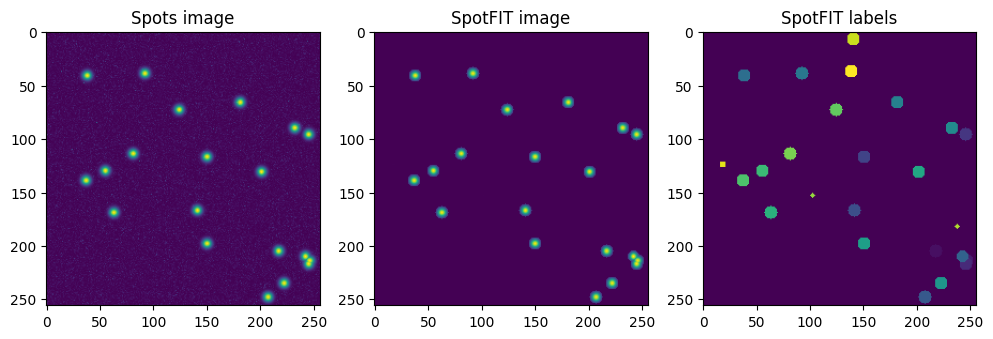

In [15]:
spotfit_img, spotfit_mask, spotfit_labels = (
    sm.utils.get_spotfit_image(df_spotfit.loc[0], spots_img.shape)
)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(spots_img.max(axis=0))
ax[0].set_title('Spots image')

ax[1].imshow(spotfit_img.max(axis=0))
ax[1].set_title('SpotFIT image')

ax[2].imshow(spotfit_labels.max(axis=0))
ax[2].set_title('SpotFIT labels')